### for kaggle notebook

In [1]:
# !pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages
# !mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
# !cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [3]:
# !pip install lightgbm
# !pip install catboost
# !pip install xgboost
# !pip install tabpfn
# !pip install seaborn
# !pip install optuna

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import StratifiedKFold

import optuna

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
import warnings
warnings.filterwarnings("ignore")

In [5]:
#from tabpfn import TabPFNClassifier
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import random, os
import math


# Flags

In [6]:
# SMOTEをTrueにすると、5FOLDの結果にリークが発生しているように見えるのでCVがあてにならなくなりそう
use_SMOTE = False
check_CV = True
del_BC_CL = False
do_opt = False
use_new_pred = True

use_GPU = False

seed = 57

# Functions

In [7]:
def calc_new_pred(pred):
    class_0_est_instances = pred[:,0].sum()
    others_est_instances = pred[:,1:].sum()
    # we reweight the probs, since the loss is also balanced like this
    # our models out of the box optimize CE
    # with these changes they optimize balanced CE
    new_p = pred * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(pred.shape[1])]])
    return new_p / np.sum(new_p,axis=1,keepdims=1)

# Read DATAS

In [48]:
df = pd.read_csv("../input/icr-identify-age-related-conditions/train.csv", index_col=[0])
greeks_df = pd.read_csv("../input/icr-identify-age-related-conditions/greeks.csv", index_col=[0])

# マジック（Epsilonを入れる）　🌟
times = greeks_df.Epsilon.copy()
times[greeks_df.Epsilon != 'Unknown'] = greeks_df.Epsilon[greeks_df.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
times[greeks_df.Epsilon == 'Unknown'] = greeks_df.Epsilon[greeks_df.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal()).median()
greeks_df['times'] = times
df = df.merge(greeks_df['times'], left_index = True, right_index = True, how='left')
new_order = df.columns.to_list()
new_order[-2], new_order[-1] = new_order[-1], new_order[-2]
df_train = df.reindex(columns=new_order)
del df

In [49]:
df_test = pd.read_csv("../input/icr-identify-age-related-conditions/test.csv", index_col=[0])
df_test['times'] = times.max()+1
df_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,times
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0


In [50]:
df_train['EJ'] = df_train['EJ'].map({'A': 0.0, 'B': 1.0}, na_action=None)
df_test['EJ'] = df_test['EJ'].map({'A': 0.0, 'B': 1.0}, na_action=None)

## nanをmedianに変更

In [51]:
col_mean = df_train.median(axis=0)
for i, colname in enumerate(df_train.columns):
    df_train[colname].fillna(col_mean[i], inplace=True)
df_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,times,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,737137.0,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,737269.0,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,737269.0,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,737269.0,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,737509.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,737681.0,0
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,737676.0,0
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,737264.0,0


In [52]:
for i, colname in enumerate(df_test.columns):
    df_test[colname].fillna(col_mean[i], inplace=True)
df_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,times
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0


### 列 BC と CL を削除
自分のコードではCVが低下したので一旦コメントアウト

https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/414638

In [53]:
if del_BC_CL:
    df_train = df_train.drop(['BC','CL'], axis=1)
    df_test = df_test.drop(['BC','CL'], axis=1)

### smote

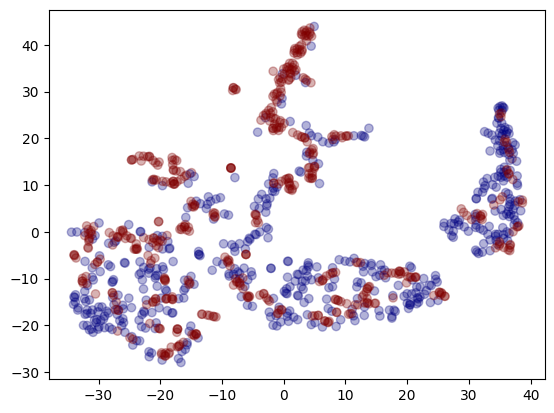

In [54]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

X = df_train[df_train.columns[:-1]]
y = df_train.Class
sm = SMOTETomek(random_state=57)
X_res, y_res = sm.fit_resample(X, y)

from sklearn.manifold import TSNE
pca = TSNE(n_components=2, random_state=0)
X_reduced_tsne = pca.fit_transform(X_res)  # wineデータをPCAで次元圧縮
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1],
            c=y_res, cmap='jet', alpha=0.3)
plt.show()

if use_SMOTE:
    X_res['Class'] = y_res
    df_train = X_res

In [55]:
df_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,times,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,737137.0,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,737269.0,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,737269.0,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,737269.0,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,737509.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,737681.0,0
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,737676.0,0
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,737264.0,0


## スケールを変更

In [56]:
df_train_noscale = df_train.copy()

scaler = RobustScaler().set_output(transform="pandas")
df_train.loc[:, df_train.columns[:-2]] = scaler.fit_transform(df_train[df_train.columns[:-2]])
df_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,times,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,-0.472222,-0.005214,0.000000,0.069272,0.000000,-1.880769,0.000000,-0.134115,1.123175,-0.463451,...,0.598571,-0.347826,-0.642283,0.000000,-0.359338,-0.716263,0.641741,-0.010025,737137.0,1
007255e47698,-0.680556,-0.989494,0.000000,0.611687,0.000000,-0.607692,0.000000,0.631510,0.000000,0.265382,...,-0.624571,0.666667,-0.819132,0.000000,1.240601,-0.124567,-0.197595,0.990161,737269.0,0
013f2bd269f5,0.375000,-0.224190,0.000000,0.440180,0.000000,0.738462,0.000000,0.488281,0.000000,0.073301,...,-0.153143,2.014493,1.581994,0.290982,0.359598,-0.218622,-0.129459,-0.006520,737269.0,0
043ac50845d5,-0.333333,0.323123,1.226427,2.105694,0.000000,-0.584615,0.000000,0.122396,0.000000,-0.440533,...,-0.624571,0.057971,-0.020900,0.178349,-0.353767,0.789556,1.101632,-0.008401,737269.0,0
044fb8a146ec,0.083333,0.283109,0.000000,-0.239281,0.000000,-0.473077,2.594595,-1.459635,26.204380,0.388671,...,46.670286,-0.289855,-0.204180,1.336815,0.042256,1.248820,-0.105640,-0.011111,737509.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,-0.666667,0.004501,1.351236,-0.410097,4.882164,-0.665385,4.594595,-0.395833,0.408759,-0.446912,...,0.128000,-0.405797,-0.847267,2.628881,0.015869,-0.504561,0.627426,0.990161,737681.0,0
fd895603f071,0.263889,1.081978,0.000000,0.968303,7.834536,0.411538,0.027027,0.446615,0.661496,0.348963,...,0.109714,0.362319,1.479904,7.718779,-0.292729,-0.081158,1.865560,-0.008881,737676.0,0
fd8ef6377f76,0.236111,-0.305510,1.574611,1.295989,1.866864,1.319231,0.000000,1.022135,0.000000,0.473846,...,-0.624571,-0.405797,0.102894,1.023740,-0.083984,-0.375590,1.748697,0.990161,737264.0,0


In [57]:
df_test_noscale = df_test.copy()

df_test.loc[:,df_test.columns[:-1]] = scaler.transform(df_test[df_test.columns[:-1]])
df_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,times
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.500798,-1.114286,-0.550725,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015532,737698.0
010ebe33f668,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.500798,-1.114286,-0.550725,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015532,737698.0
02fa521e1838,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.500798,-1.114286,-0.550725,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015532,737698.0
040e15f562a2,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.500798,-1.114286,-0.550725,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015532,737698.0
046e85c7cc7f,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.500798,-1.114286,-0.550725,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015532,737698.0


In [58]:
df_train['times'] = df_train.times.astype(int)
df_test['times'] = df_test.times.astype(int)

# PyTorch

In [59]:
class cfg :
    TRAIN_BATCHSIZE = 32
    VALID_BATCHSIZE = 32
    learning_rate = 0.001
    num_epochs = 1000
    seed = 57

### dataset/dataloader

In [68]:
class MyDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df

    # ここで取り出すデータを指定している
    def __getitem__(
        self,
        index
    ) :
#         print(index, self.df.iloc[index])
        data = torch.Tensor(self.df.iloc[index, :-2].to_numpy())
        label = self.df.Class[index]
        
        return data, label

    # この method がないと DataLoader を呼び出す際にエラーを吐かれる
    def __len__(self) -> int:
        return len(self.df)

### model

In [69]:
"""
margin: 通常、2クラス分類ではmarginの値は0.2から0.5の範囲で設定されます。
    この範囲内での値の選択は、同じクラスの特徴ベクトルを近くに、異なるクラスの
    特徴ベクトルを遠くに分離する効果を持ちます。具体的な値は実験によって調整する
    必要がありますが、一般的には0.3や0.4が試されることが多いです。
scale: 2クラス分類の場合、scaleの値は一般的に10から30程度が使用されます。
    値が大きいほど、クラス分類の確信度が高まりますが、適切な値はデータセットやタスクに
    依存します。一般的な出発点としては、10や20を試してみることができます。
"""
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, train, label=False):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        if train:
            one_hot = torch.zeros(cosine.size())
            one_hot.scatter_(1, label.view(-1, 1).long(), 1)
#             one_hot = torch.zeros(cosine.size(), device='cuda')
#             one_hot.scatter_(1, label.cuda().view(-1, 1).long(), 1)
            output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        else:
            output = cosine
        output *= self.s

        return output

In [70]:
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, last_hidden_dim=64):
        super(MyModel, self).__init__()

#         self.bn1 = nn.BatchNorm1d(input_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
#         self.bn3 = nn.BatchNorm1d(last_hidden_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, last_hidden_dim)
        self.arcface = ArcMarginProduct(last_hidden_dim, output_dim, s = 10, m = 0.1)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x, labels):
#         x = self.bn1(x)
        x = F.mish(self.bn2(self.fc1(x)))
        x = self.dropout(x)
#         x = F.mish(self.bn3(self.fc2(x)))
        x = self.dropout(x)
        if self.training:
            logits = self.arcface(x, self.training, labels)
        else:
            logits = self.arcface(x, self.training)
        return logits, x


In [71]:
def balanced_log_loss(y_true, y_pred):
    y_pred = y_pred.astype('float64')
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    balanced_log_loss_score = (-w0/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(1-y_pred))) - w1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred)))) / (w0+w1)
    return balanced_log_loss_score

In [72]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
# criterion = F.cross_entropy

In [73]:
balance = torch.Tensor([len(df_train)/sum(df_train.Class == i) for i in range(len(df_train.Class.unique()))])
balance /= sum(balance)
balance

tensor([0.1750, 0.8250])

### train

In [74]:
def train(fold, train_dataloader,valid_dataloader, input_dim, output_dim):
    best_score = 10**18
    model = MyModel(input_dim, output_dim)

    optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
    criterion = nn.CrossEntropyLoss(weight=balance)
    
    for epoch in range(cfg.num_epochs):
        y_true = []
        y_pred = []    

        model.train()  # モデルを訓練モードに設定
        total_loss = 0.0
        for batch in train_dataloader:
            inputs, labels = batch
            optimizer.zero_grad()  # 勾配の初期化
            # フォワード処理
            outputs, _ = model(inputs, labels)      
            # 損失の計算
            loss = criterion(outputs, labels)
            # バックワード処理
            loss.backward()
            # パラメータの更新
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_dataloader)

        model.eval()  # モデルをvalidモードに設定
        total_loss = 0.0


        for batch in valid_dataloader:
            inputs, labels = batch
            with torch.no_grad():
                outputs, _ = model(inputs, labels)     
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            y_true += (labels.detach().tolist())
            y_pred += (1 - F.softmax(outputs, dim=1)[:, 0]).detach().tolist()
        avg_valid_loss = total_loss / len(valid_dataloader)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        score = balanced_log_loss(y_true, y_pred)

    #     if (epoch+1)%10 == 0 or best_score > score:
        if (epoch+1)%100 == 0:
            print(f"Epoch {epoch+1}/{cfg.num_epochs}, train Loss: {avg_train_loss:.4f}",
                  f" : valid Loss: {avg_valid_loss:.4f}, score = {score}")
#         if epoch > 100 and best_score > score and avg_valid_loss > avg_train_loss:
        if epoch > 100 and best_score > score:
            print(f"Epoch {epoch+1}/{cfg.num_epochs}, train Loss: {avg_train_loss:.4f}",
                  f" : valid Loss: {avg_valid_loss:.4f}, score = {score} Saved.")
            best_score = min(best_score, score)
            torch.save(model.state_dict(), f"model_weight_fold{fold}.pth")

    torch.save(model.state_dict(), f"model_weight_last_fold{fold}.pth")

    return best_score


In [76]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
num = 0
seed_everything(cfg.seed)
score = 0

# timesは入れない！！！！
input_dim = len(df_train.columns)-2
output_dim = len(df_train.Class.unique())


for train_idx, valid_idx in kf.split(df_train, df_train.Class):
    train_df = df_train.iloc[train_idx]
    valid_df = df_train.iloc[valid_idx]
    train_dataset = MyDataset(train_df)
    valid_dataset = MyDataset(valid_df)
    train_dataloader = DataLoader(train_dataset, batch_size=cfg.TRAIN_BATCHSIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.VALID_BATCHSIZE, shuffle=False)
    
    print(f"Fold{num}")
    score += train(num, train_dataloader, valid_dataloader, input_dim, output_dim)
    
    num+=1

score/5

Fold0
Epoch 100/1000, train Loss: 0.5152  : valid Loss: 0.4473, score = 0.5808651281001976
Epoch 102/1000, train Loss: 0.4737  : valid Loss: 0.4749, score = 0.6560397923612415 Saved.
Epoch 104/1000, train Loss: 0.5232  : valid Loss: 0.4105, score = 0.6164775415871301 Saved.
Epoch 105/1000, train Loss: 0.5078  : valid Loss: 0.3892, score = 0.58020432829261 Saved.
Epoch 106/1000, train Loss: 0.5314  : valid Loss: 0.3551, score = 0.44504766659016287 Saved.
Epoch 113/1000, train Loss: 0.4912  : valid Loss: 0.3459, score = 0.43701604618471707 Saved.
Epoch 129/1000, train Loss: 0.5158  : valid Loss: 0.3393, score = 0.40844569130925146 Saved.
Epoch 141/1000, train Loss: 0.4724  : valid Loss: 0.3332, score = 0.3650896198652498 Saved.
Epoch 145/1000, train Loss: 0.5029  : valid Loss: 0.3452, score = 0.3553238459087441 Saved.
Epoch 174/1000, train Loss: 0.5399  : valid Loss: 0.2946, score = 0.33669130791003865 Saved.
Epoch 175/1000, train Loss: 0.4684  : valid Loss: 0.3346, score = 0.30708961707

0.2725862761264811

### 予測用の関数等の定義

In [77]:
nn_models = []
for i in range(5):
    model = MyModel(input_dim, output_dim)
    model.load_state_dict(torch.load(f'model_weight_fold{i}.pth'))
    model.eval()  ## torch.nn.Module.eval
    nn_models.append(model)

In [111]:
def nn_predict_proba(X):
    preds = []
    for model in nn_models:
        with torch.no_grad():
            pred, feature = model(X, None)
        pred = F.softmax(pred).detach().numpy()

        if len(preds) == 0:
            preds = pred
        else:
            preds += pred

    preds = preds/5
    return preds

In [114]:
X = torch.Tensor(df_train[df_train.columns[:-2]].to_numpy())
y = df_train.Class

preds = nn_predict_proba(X)
preds

array([[5.8127358e-03, 9.9418724e-01],
       [9.9941623e-01, 5.8368419e-04],
       [9.2619383e-01, 7.3806182e-02],
       ...,
       [9.9008399e-01, 9.9159926e-03],
       [9.6343786e-01, 3.6562122e-02],
       [9.4255650e-01, 5.7443541e-02]], dtype=float32)

In [113]:
balanced_log_loss(y, preds[:, 1])

0.12060321408089028

# LightGBM/XGBoost/CatBoost

In [17]:
classes_weights = compute_sample_weight(
    class_weight='balanced',
    y=df_train.Class
)
len(classes_weights)

617

In [18]:
def balanced_log_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    balanced_log_loss_score = (-w0/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(1-y_pred))) - w1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred)))) / (w0+w1)
    return balanced_log_loss_score

# 独自の評価関数をスコアリング関数に変換
balanced_log_loss_scorer = make_scorer(balanced_log_loss, greater_is_better=False)

## optuna

In [19]:
# 初期設定値
lgbm_params = {'n_estimators': 590,
 'reg_alpha': 3.3000000000000003,
 'reg_lambda': 36.4,
 'num_leaves': 25,
 'min_child_samples': 40,
 'colsample_bytree': 0.7,
 'subsample': 0.9,
 'subsample_freq': 1}
 
xgb_params = {'n_estimators': 700,
 'max_depth': 3,
 'learning_rate': 0.03560016067885742,
 'subsample': 0.7408505704121144,
 'colsample_bytree': 0.5705779083310649,
 'gamma': 0.5286651204230014}
 
cb_params = {'iterations': 114,
 'depth': 4,
 'learning_rate': 0.08433020501242801,
 'random_strength': 1,
 'bagging_temperature': 0.1111714827952525,
 'od_wait': 23}


rf_params = {'criterion': 'log_loss',
 'bootstrap': False,
 'max_depth': 514,
 'max_features': 'sqrt',
 'max_leaf_nodes': 14,
 'n_estimators': 93,
 'min_samples_split': 3,
 'min_samples_leaf': 9}

### lightGBM

In [20]:
def obj_lgbm(trial):
    params = {
        'boosting_type':'gbdt',
        'class_weight':'balanced',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 100, step=0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 100, step=0.1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 64, step=1),
        'min_child_samples': trial.suggest_int('min_child_samples', 8, 64, step=1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 3, step=1),
    }
    
    model = LGBMClassifier(**params)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    score = 0
    for train_idx, valid_idx in kf.split(df_train, df_train.Class):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

        weights = classes_weights[train_idx]
        model.fit(X_train, y_train, sample_weight=weights)
        y_pred = model.predict_proba(X_valid)
        loss = balanced_log_loss(y_valid, y_pred[:, 1])
        score += loss

    return score/5
        

if do_opt :
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))#direction='minimize')
    study.enqueue_trial(lgbm_params)
    study.optimize(obj_lgbm, n_trials=100)

In [21]:
#0.18265121471197596
if do_opt :
    lgbm_params = dict(study.best_trial.params.items())
lgbm_params

{'n_estimators': 590,
 'reg_alpha': 3.3000000000000003,
 'reg_lambda': 36.4,
 'num_leaves': 25,
 'min_child_samples': 40,
 'colsample_bytree': 0.7,
 'subsample': 0.9,
 'subsample_freq': 1}

### xgboost

In [22]:
def obj_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.001, 1.0, log=True),
        'objective': 'binary:logistic', 
        'eval_metric': 'logloss', 
    }

    model = XGBClassifier(**params)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    score = 0
    for train_idx, valid_idx in kf.split(df_train, df_train.Class):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

        weights = classes_weights[train_idx]
        model.fit(X_train, y_train, sample_weight=weights)
        y_pred = model.predict_proba(X_valid)
        loss = balanced_log_loss(y_valid, y_pred[:, 1])
        score += loss

    return score/5
        
if do_opt :    
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed))#direction='minimize')
    study.enqueue_trial(xgb_params)
    study.optimize(obj_xgb, n_trials=100)

In [23]:
if do_opt :
    xgb_params = dict(study.best_trial.params.items())

xgb_params

{'n_estimators': 700,
 'max_depth': 3,
 'learning_rate': 0.03560016067885742,
 'subsample': 0.7408505704121144,
 'colsample_bytree': 0.5705779083310649,
 'gamma': 0.5286651204230014}

### catboost

In [24]:
def obj_cb(trial):
    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.3, log=True),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_float('bagging_temperature', 0.01, 100.00, log=True), 
#         'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }

    
    if use_GPU:
        model = CatBoostClassifier(**cb_params, task_type="GPU")
    else:
        model = CatBoostClassifier(**params)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    score = 0
    for train_idx, valid_idx in kf.split(df_train, df_train.Class):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

        weights = classes_weights[train_idx]
        model.fit(X_train, y_train, logging_level="Silent", sample_weight=weights)
        y_pred = model.predict_proba(X_valid)
        loss = balanced_log_loss(y_valid, y_pred[:, 1])
        score += loss

    return score/5
        
if do_opt :
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed))#direction='minimize')
    study.enqueue_trial(cb_params)
    study.optimize(obj_cb, n_trials=50)

In [25]:
if do_opt :
    cb_params = dict(study.best_trial.params.items())
cb_params

{'iterations': 114,
 'depth': 4,
 'learning_rate': 0.08433020501242801,
 'random_strength': 1,
 'bagging_temperature': 0.1111714827952525,
 'od_wait': 23}

### random forest

In [26]:
def obj_rf(trial):
    params = {
        'criterion' :trial.suggest_categorical('criterion', ['gini', 'log_loss', 'entropy']),
        'bootstrap' : trial.suggest_categorical('bootstrap',[True, False]),
        'max_depth' : trial.suggest_int('max_depth', 1, 1000),
        'max_features' : trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 300),
        'n_estimators' :  trial.suggest_int('n_estimators', 5, 300),
        'min_samples_split' : trial.suggest_int('min_samples_split',2,5),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf',1,10) ,      
    }
    
    
    model = RandomForestClassifier(**params)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    score = 0
    for train_idx, valid_idx in kf.split(df_train, df_train.Class):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

        weights = classes_weights[train_idx]
        model.fit(X_train, y_train, sample_weight=weights)
        y_pred = model.predict_proba(X_valid)
        loss = balanced_log_loss(y_valid, y_pred[:, 1])
        score += loss

    return score/5
        
if do_opt :    
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed))#direction='minimize')
    study.enqueue_trial(rf_params)
    study.optimize(obj_rf, n_trials=100)

In [27]:
if do_opt :
    rf_params = dict(study.best_trial.params.items())
rf_params

{'criterion': 'log_loss',
 'bootstrap': False,
 'max_depth': 514,
 'max_features': 'sqrt',
 'max_leaf_nodes': 14,
 'n_estimators': 93,
 'min_samples_split': 3,
 'min_samples_leaf': 9}

In [28]:
"""
lgbm_params = {'n_estimators': 600,
 'reg_alpha': 2.8000000000000003,
 'reg_lambda': 12.4,
 'num_leaves': 41}
 
xgb_params = {'n_estimators': 800,
 'max_depth': 4,
 'learning_rate': 0.07321832691960338,
 'subsample': 0.7576690053727902,
 'colsample_bytree': 0.7481165187056286,
 'gamma': 0.4338012239235796}
 
cb_params = {'iterations': 114,
 'depth': 4,
 'learning_rate': 0.08433020501242801,
 'random_strength': 1,
 'bagging_temperature': 0.1111714827952525,
 'od_wait': 23}
"""

"\nlgbm_params = {'n_estimators': 600,\n 'reg_alpha': 2.8000000000000003,\n 'reg_lambda': 12.4,\n 'num_leaves': 41}\n \nxgb_params = {'n_estimators': 800,\n 'max_depth': 4,\n 'learning_rate': 0.07321832691960338,\n 'subsample': 0.7576690053727902,\n 'colsample_bytree': 0.7481165187056286,\n 'gamma': 0.4338012239235796}\n \ncb_params = {'iterations': 114,\n 'depth': 4,\n 'learning_rate': 0.08433020501242801,\n 'random_strength': 1,\n 'bagging_temperature': 0.1111714827952525,\n 'od_wait': 23}\n"

In [29]:
# lgb = LGBMClassifier(boosting_type='gbdt', class_weight='balanced', colsample_bytree=1.0,
#                 importance_type='split', learning_rate=0.1, max_depth=-1,
#                 min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
#                 n_estimators=100, n_jobs=-1, num_leaves=31, objective="binary",
#                 random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
#                 subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
# xgb = XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
#                colsample_bylevel=None, colsample_bynode=None,
#                colsample_bytree=None, early_stopping_rounds=None,
#                enable_categorical=False, eval_metric=None, feature_types=None,
#                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
#                interaction_constraints=None, learning_rate=None, max_bin=None,
#                max_cat_threshold=None, max_cat_to_onehot=None,
#                max_delta_step=None, max_depth=None, max_leaves=None,
#                min_child_weight=None, monotone_constraints=None,
#                n_estimators=100, n_jobs=-1, num_parallel_tree=None,
#                objective='binary:logistic', predictor=None)

# cb = CatBoostClassifier()
# tab = TabPFNClassifier(N_ensemble_configurations=64)

In [30]:
lgb = LGBMClassifier(boosting_type='gbdt', class_weight='balanced', **lgbm_params)
xgb = XGBClassifier(
    objective = 'binary:logistic', 
    eval_metric = 'logloss', 
    **xgb_params,
)


rf = RandomForestClassifier(**rf_params)

if use_GPU:
    cb = CatBoostClassifier(**cb_params, task_type="GPU")
    tab = TabPFNClassifier(N_ensemble_configurations=64, device='cuda:0')
else:
    cb = CatBoostClassifier(**cb_params)
    tab = TabPFNClassifier(N_ensemble_configurations=64)
    

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


## calc cv (5 fold)

In [32]:
if check_CV:
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    score = 0
    
    
    y_preds = []
    y_true = []
    
    for train_idx, valid_idx in kf.split(df_train, df_train.Class):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

    #     # SMOTETomek
    #     if use_SMOTE:
    #         sm = SMOTETomek(random_state=57)
    #         X_train, y_train = sm.fit_resample(X_train, y_train)
    #         weights = compute_sample_weight(class_weight='balanced',y=y_train)                              
    #     else:
        weights = classes_weights[train_idx]

        print("lgbm..")
        lgb.fit(X_train, y_train, sample_weight=weights)
        y_lgb = lgb.predict_proba(X_valid)
        print("xgboost..")    
        xgb.fit(X_train, y_train, sample_weight=weights)
        y_xgb = xgb.predict_proba(X_valid)
        print("catboost..")
        cb.fit(X_train, y_train, logging_level="Silent", sample_weight=weights)
        y_cb = cb.predict_proba(X_valid)
        print("random forest..")
        rf.fit(X_train, y_train, sample_weight=weights)
        y_rf = rf.predict_proba(X_valid)


        train_df = df_train_noscale.iloc[train_idx]
        valid_df = df_train_noscale.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

        print("TabPFN..")
        tab.fit(X_train, y_train)
        y_tab = tab.predict_proba(X_valid)
        y_tab = calc_new_pred(y_tab)
                
        lgb_loss = balanced_log_loss(y_valid, y_lgb[:, 1])
        xgb_loss = balanced_log_loss(y_valid, y_xgb[:, 1])
        cb_loss = balanced_log_loss(y_valid, y_cb[:, 1])
        rf_loss = balanced_log_loss(y_valid, y_rf[:, 1])
        tab_loss = balanced_log_loss(y_valid, y_tab[:, 1])
        
        pred = ((y_lgb + y_xgb + y_cb)/3 + y_rf + y_tab)/3
        if use_new_pred:
            pred = calc_new_pred(pred)

        if len(y_preds) == 0 :
            y_preds = np.concatenate([y_lgb, y_xgb, y_cb, y_rf, y_tab], axis=1)
            y_true = y_valid.to_numpy()
        else:
            y_preds = np.vstack([y_preds, np.concatenate([y_lgb, y_xgb, y_cb, y_rf, y_tab], axis=1)])
            y_true = np.hstack([y_true, y_valid.to_numpy()])
            
        e_loss = balanced_log_loss(y_valid, pred[:, 1])
        score += e_loss 
        print("lgb", lgb_loss, "xgb", xgb_loss, "catboost", cb_loss, "rf", rf_loss,"TabPFN", tab_loss, "ensamble", e_loss)

    print(score/5)

lgbm..
xgboost..
catboost..
random forest..
TabPFN..
lgb 0.15859814509284034 xgb 0.2894700296788736 catboost 0.29502666091022894 rf 0.38707912177940257 TabPFN 0.39833711216805606 ensamble 0.18005271128854689
lgbm..
xgboost..
catboost..
random forest..
TabPFN..
lgb 0.13482534102391344 xgb 0.3008598644203285 catboost 0.26575951952580235 rf 0.4223423733890963 TabPFN 0.1437194111933784 ensamble 0.1430152031994494
lgbm..
xgboost..
catboost..
random forest..
TabPFN..
lgb 0.1997997539065799 xgb 0.35353813781033017 catboost 0.3478388928467493 rf 0.4802681882273381 TabPFN 0.2988183146392546 ensamble 0.2016415524786051
lgbm..
xgboost..
catboost..
random forest..
TabPFN..
lgb 0.2997250748586222 xgb 0.4368994117420579 catboost 0.44411193297730184 rf 0.47499281188744763 TabPFN 0.47174863978583104 ensamble 0.23444726731605905
lgbm..
xgboost..
catboost..
random forest..
TabPFN..
lgb 0.13880528180543375 xgb 0.16711713838340767 catboost 0.238519776750122 rf 0.3602965538140653 TabPFN 0.1349060812860147 

### スタッキング（２段目）

2段目は、各FOLDのvalidデータを用いて学習させる。こうしないとリークする可能性がありそうなので。

In [33]:
if check_CV:
    xgb2_params = {
        'n_estimators': 100, 
        'max_depth': 5, 
        'random_state': seed
    }
    xgb2 = XGBClassifier(
        objective = 'binary:logistic', 
        eval_metric = 'logloss', 
        **xgb2_params,
    )

    xgb2.fit(y_preds, y_true)
    pred2 = xgb2.predict_proba(y_preds)
    print(balanced_log_loss(y_true, pred2[:, 1]))

0.03771430829256337


In [34]:
"""
0.29157091126262846

 ((y_lgb + y_xgb + y_cb)/3 + y_tab)/2  ==> 0.16668635490617328 -> tabpfn use new_pred 0.16034929034467685
 ((y_lgb + y_xgb + y_cb)/3 + y_rf + y_tab)/3 0.17872250255179017 rfは微妙？
"""
#display(df_train)
# display(df_train_noscale)

'\n0.29157091126262846\n\n ((y_lgb + y_xgb + y_cb)/3 + y_tab)/2  ==> 0.16668635490617328 -> tabpfn use new_pred 0.16034929034467685\n ((y_lgb + y_xgb + y_cb)/3 + y_rf + y_tab)/3 0.17872250255179017 rfは微妙？\n'

## fit models(final parameter)

In [35]:
X = df_train[df_train.columns[:-1]]
y = df_train.Class

In [36]:
lgb.fit(X, y, sample_weight=classes_weights)
y_lgb = lgb.predict_proba(X)
balanced_log_loss(y, y_lgb[:, 1])

0.042406137550189245

In [37]:
xgb.fit(X, y, sample_weight=classes_weights)
y_xgb = xgb.predict_proba(X)
balanced_log_loss(y, y_xgb[:, 1])

0.018894730607369185

In [38]:
cb.fit(X, y, logging_level="Silent", sample_weight=classes_weights)
y_cb = cb.predict_proba(X)
balanced_log_loss(y, y_cb[:, 1])

0.04207514032249527

In [39]:
rf.fit(X, y, sample_weight=classes_weights)
y_rf = rf.predict_proba(X)
balanced_log_loss(y, y_rf[:, 1])

0.20361171771850825

In [40]:
# tabpfnには正則化する前のデータを入力する
X = df_train_noscale[df_train.columns[:-1]]
y = df_train_noscale.Class

In [41]:
tab.fit(X, y)
y_tab = tab.predict_proba(X)
y_tab = calc_new_pred(y_tab) # <- ここに入れるのは良いかも
balanced_log_loss(y, y_tab[:, 1])

0.019584547516212653

In [49]:
pred = ((y_lgb + y_xgb + y_cb)/3 + y_rf + y_tab)/3
balanced_log_loss(y,pred[:, 1])

0.08048233466584549

In [43]:
pred = calc_new_pred(pred)
balanced_log_loss(y, pred[:, 1])

0.06840488357193353

In [44]:
y_preds = np.concatenate([y_lgb, y_xgb, y_cb, y_rf, y_tab], axis=1)
pred2 = xgb2.predict_proba(y_preds)
balanced_log_loss(y, pred2[:, 1])

0.003776845928816813

# infer

In [667]:
pred_lgb = lgb.predict_proba(df_test)
pred_xgb = xgb.predict_proba(df_test)
pred_cb = cb.predict_proba(df_test)
pred_rf = rf.predict_proba(df_test)
pred_tab = tab.predict_proba(df_test_noscale)
pred_tab = calc_new_pred(pred_tab)
pred = ((pred_lgb + pred_xgb + pred_cb)/3 + pred_rf + pred_tab)/3
preds = np.concatenate([pred_lgb, pred_xgb, pred_cb, pred_rf, pred_tab], axis=1)
pred = xgb2.predict_proba(preds)

if use_new_pred:
    pred = calc_new_pred(pred)

pred

array([[0.49999999, 0.50000001],
       [0.49999999, 0.50000001],
       [0.49999999, 0.50000001],
       [0.49999999, 0.50000001],
       [0.49999999, 0.50000001]])

In [668]:
submission = pd.read_csv('../input/icr-identify-age-related-conditions/sample_submission.csv')
submission['class_0'] = pred[:,0]
submission['class_1'] = pred[:,1]

In [669]:
submission.to_csv('submission.csv', index=False)
submission

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5
